# Physically Consistent Deep Learning



In [ ]:
import torch
from torch.func import jacrev, hessian, vmap
import matplotlib.pyplot as plt
import time
import numpy as np

## Task 1: ODE solution

Find $y(x)$ that satisfies $\mathcal{N}[y,x] = \frac{d^2 y}{d x^2} + y = 0$

### Prepare Data

We first prepare a dataset $\{(x,y)\}$ that satisfies the DE
The dataset has very few datapoints (to test data efficiency) and with noise (to test robustness)

In [ ]:
# Generation of synthetic dataset
def generate_data(interval = (-torch.pi, torch.pi), num_samples= 1000, A = 1.0, phi = 0.0):
  X = (interval[1]-interval[0]) * torch.rand((num_samples, 1), requires_grad= True) + interval[0]

  f = lambda x : A*torch.cos(x + phi)
  Y = f(X)
  print(f"Generated dataset with {num_samples} samples, x in interval [{X.min().item():.2f}, {X.max().item():.2f}], y(x) = {A:.2f} cos(x {phi:+.2f})")

  # check if the differential equation N[y,x] = 0 holds

  ## compute first derivative (jacobian)
  df_dx = vmap(jacrev(f))
  dY_dX = df_dx(X).reshape(Y.shape)

  ## compute second derivative (hessian)
  d2f_dx2 = vmap(hessian(f))
  d2Y_dX2 = d2f_dx2(X).reshape(Y.shape)

  ## compute N[y,x]
  N = d2Y_dX2 + Y
  if torch.allclose(torch.mean(torch.square(N)), torch.tensor(0.)) :
    print("Differential equation holds")
  else:
    print("Something went wrong, Differential equation doesn't hold")
  return (X,Y)

def generate_train_test(interval_train, num_samples_train, interval_test, num_samples_test):
  A = 3* torch.rand(()) + 1 # random number between [1, 4]
  phi = 2 * torch.pi * torch.rand(()) - torch.pi # random number between [-pi, pi]
  return generate_data(interval_train, num_samples_train, A, phi), generate_data(interval_test, num_samples_test, A, phi)


# very few data points + noise
# range of test data is wider to test generalization to unseen scenarios
# 50 points for training |
(X_train, Y_train), (X_test, Y_test) = generate_train_test([-5, 5], 50, [-10, 10], 1000)
X_train += 0.1 * torch.randn_like(X_train)
Y_train += 0.1 * torch.randn_like(Y_train)

Generated dataset with 50 samples, x in interval [-4.93, 4.95], y(x) = 3.73 cos(x -0.29)
Differential equation holds
Generated dataset with 1000 samples, x in interval [-9.97, 9.99], y(x) = 3.73 cos(x -0.29)
Differential equation holds


### Prepare the model $f_{NN}(x; \theta)$ and its derivatives


- `vmap` is the vectorization map operator, it takes a function and gives a batched version of the same function. If $f: \mathbb{R} \rightarrow \mathbb{R}$. Then $\text{vmap}(f) =  f' : \mathbb{R^{n}} → \mathbb{R^{n}}$
- `jacrev` is the jacobian operator (using reverse autograd), it takes a function $f(x)$ and gives a function $\frac{\partial f}{\partial x} (x)$.
- `hessian` is the hessian operator, it takes a function $f(x)$ and gives a function $\frac{\partial^2 f}{\partial x^2} (x)$.

These functions are part of the functional API of PyTorch that is similar to JAX.

In [ ]:
def get_model_and_derivatives(hidden_channels = (64, 64), activation = torch.nn.GELU, device= "cpu"):
  # construct a simple MLP
  layers = []
  inp = 1
  for h in hidden_channels:
      layers.append(torch.nn.Linear(inp, h))
      layers.append(activation())
      inp = h
  layers.append(torch.nn.Linear(inp, 1))
  model =  torch.nn.Sequential(*layers).to(device)

  # functions to compute the output and its derivatives
  # we use functions because jacrev, hessian, vmap ... requires a function and not nn.Module
  # that's why the API is called "functional"
  f = lambda x : model(x)
  df_dx = vmap(jacrev(f))
  d2f_dx2 = vmap(hessian(f))

  return (f, df_dx, d2f_dx2), model.parameters()

### Testing routine

In [ ]:
def test_model(f, X, Y):
  # simple check for f(X) vs Y,
  print(f"MSE: {torch.nn.functional.mse_loss(f(X), Y)}")
  sorted_indices = torch.argsort(X.flatten())
  X = X[sorted_indices].reshape(-1,1)
  Y = Y[sorted_indices].reshape(-1,1)
  plt.plot(X.detach().cpu(), Y.detach().cpu(), label= 'Act')
  plt.plot(X.detach().cpu(), f(X).detach().cpu(), label= 'Pred')
  plt.legend()
  plt.plot()

### Train a black-box deep learning model

t: 0.20, Epoch 100: MSE: 0.0477, LR: 0.009649
t: 0.31, Epoch 200: MSE: 0.0439, LR: 0.008644
t: 0.41, Epoch 300: MSE: 0.0426, LR: 0.007127
t: 0.51, Epoch 400: MSE: 0.0417, LR: 0.005311
t: 0.60, Epoch 500: MSE: 0.0410, LR: 0.003451
t: 0.70, Epoch 600: MSE: 0.0405, LR: 0.001809
t: 0.80, Epoch 700: MSE: 0.0402, LR: 0.000616
t: 0.93, Epoch 800: MSE: 0.0401, LR: 0.000039
t: 1.02, Epoch 900: MSE: 0.0401, LR: 0.000159
t: 1.11, Epoch 1000: MSE: 0.0400, LR: 0.000959
t: 1.21, Epoch 1100: MSE: 0.0394, LR: 0.002328
t: 1.31, Epoch 1200: MSE: 0.0394, LR: 0.004072
t: 1.40, Epoch 1300: MSE: 0.1355, LR: 0.005947
t: 1.50, Epoch 1400: MSE: 0.0358, LR: 0.007688
t: 1.60, Epoch 1500: MSE: 0.0354, LR: 0.009052
t: 1.70, Epoch 1600: MSE: 0.0351, LR: 0.009846
t: 1.79, Epoch 1700: MSE: 0.0348, LR: 0.009959
t: 1.87, Epoch 1800: MSE: 0.0348, LR: 0.009375
t: 1.96, Epoch 1900: MSE: 0.0343, LR: 0.008176
t: 2.06, Epoch 2000: MSE: 0.0341, LR: 0.006531
t: 2.16, Epoch 2100: MSE: 0.0340, LR: 0.004670
t: 2.25, Epoch 2200: M

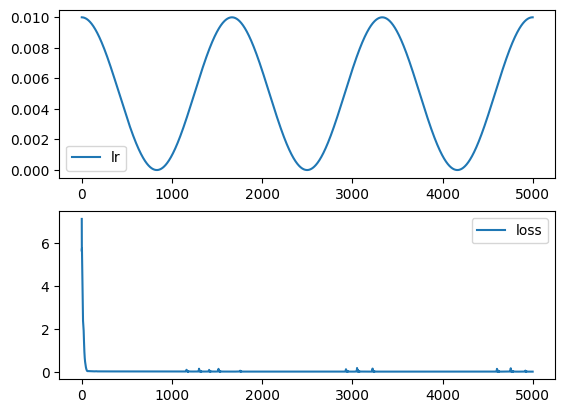

In [ ]:
lr = 0.01
num_epochs = 5000
T_scheduler = num_epochs // 6
device = "cpu"
loss_fun = torch.nn.MSELoss()

(f, _, _), params = get_model_and_derivatives(device=device)
optim = torch.optim.Adam(params, lr= lr)
# We use a CosineAnnealingLR scheduler to help avoid local minima
# it helps excite the training process which could pull the weights from
# a gradient local minima

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)

lrs = []
losses = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

start_time = time.time()
for epoch in range(num_epochs):
  optim.zero_grad()

  Y_pred = f(X_train)
  loss_mse = loss_fun(Y_train, Y_pred)
  loss = loss_mse
  loss.backward(retain_graph= True)
  optim.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
  losses.append(loss.item())
  if (epoch + 1)%100 == 0:
    print(f"t: {time.time()-start_time:.2f}, Epoch {epoch+1}: MSE: {loss_mse.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

plt.subplot(2, 1, 1)
plt.plot(lrs, label= 'lr')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()


MSE: 0.03197798505425453


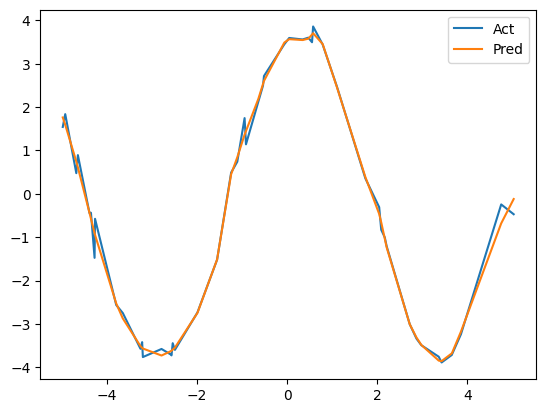

In [ ]:
test_model(f, X_train, Y_train)

MSE: 32.48612594604492


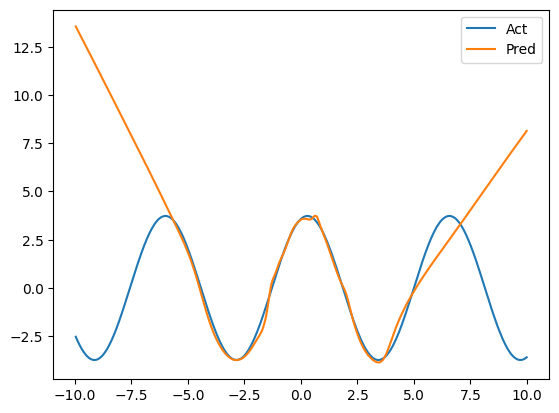

In [ ]:
test_model(f, X_test, Y_test)

We can see signs for overfitting and poor generlization

### Train a PINN deep learning model

t: 0.84, Epoch 100: MSE: 0.0610, Phys: 0.0042, LR: 0.003419
t: 1.67, Epoch 200: MSE: 0.0608, Phys: 0.0032, LR: 0.001000
t: 2.49, Epoch 300: MSE: 0.0605, Phys: 0.0030, LR: 0.009111
t: 3.28, Epoch 400: MSE: 0.0607, Phys: 0.0022, LR: 0.006400
t: 4.15, Epoch 500: MSE: 0.0607, Phys: 0.0021, LR: 0.000004
t: 5.01, Epoch 600: MSE: 0.0607, Phys: 0.0021, LR: 0.006759
t: 5.81, Epoch 700: MSE: 0.0607, Phys: 0.0028, LR: 0.008884
t: 6.65, Epoch 800: MSE: 0.0607, Phys: 0.0024, LR: 0.000784
t: 7.78, Epoch 900: MSE: 0.0607, Phys: 0.0024, LR: 0.003782
t: 8.59, Epoch 1000: MSE: 0.0607, Phys: 0.0022, LR: 0.009986


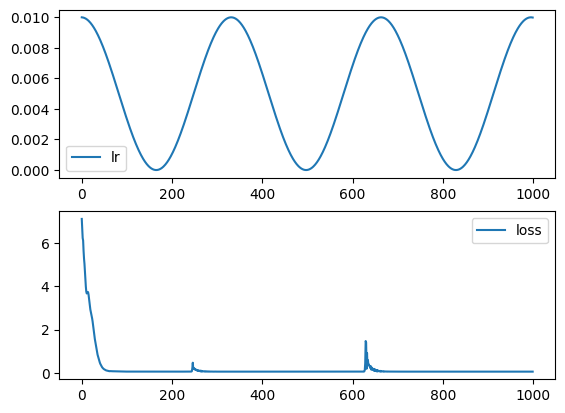

In [ ]:
lr = 0.01
num_epochs = 1000
T_scheduler = num_epochs // 6
coeff_phys = 1.0
device = "cpu"
loss_fun = torch.nn.MSELoss()

(f, _, d2f_dx2), params = get_model_and_derivatives(device=device)
optim = torch.optim.Adam(params, lr= lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)

lrs = []
losses_mse = []
losses_phys = []
losses = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

start_time = time.time()
for epoch in range(num_epochs):
  optim.zero_grad()
  Y_pred = f(X_train)
  loss_mse = loss_fun(Y_train, Y_pred)


  # we add a loss function for the constraint d2y_dx2 - y = 0
  d2Y_dX2_pred = d2f_dx2(X_train).reshape(-1,1)
  loss_phys = loss_fun(d2Y_dX2_pred, -Y_pred)
  #
  loss = loss_mse + coeff_phys * loss_phys
  loss.backward(retain_graph= True)
  optim.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
  losses_mse.append(loss_mse.item())
  losses_phys.append(loss_phys.item())
  losses.append(loss.item())
  if (epoch + 1)%100 == 0:
    print(f"t: {time.time() - start_time:.2f}, Epoch {epoch+1}: MSE: {loss_mse.item():.4f}, Phys: {loss_phys.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

plt.subplot(2, 1, 1)
plt.plot(lrs, label= 'lr')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()


MSE: 0.06066485494375229


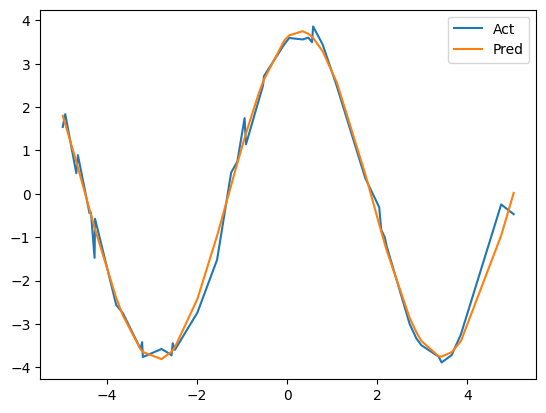

In [ ]:
test_model(f, X_train, Y_train)

MSE: 39.9593505859375


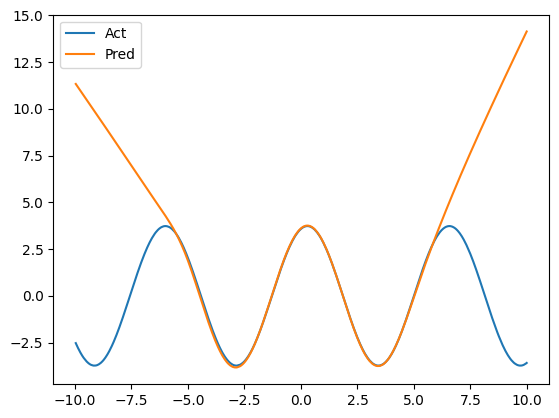

In [ ]:
test_model(f, X_test, Y_test)

We can already see that the physica loss has regulerization effect, even with noisy data, the physical constraint decreased overfitting

### Train a PINN deep learning model - 2nd try

We will use extra data points $x$ that we don't $y$ for. However, we know that $\frac{\partial^2 f}{\partial x^2}(x) - f(x) = 0$  

t: 3.57, Epoch: 100: MSE: 0.5440, Phys1: 0.4164,Phys2: 0.5918,  LR: 0.009649
t: 7.34, Epoch: 200: MSE: 0.2826, Phys1: 0.1843,Phys2: 0.4637,  LR: 0.008644
t: 10.71, Epoch: 300: MSE: 0.1524, Phys1: 0.0954,Phys2: 0.3777,  LR: 0.007127
t: 14.00, Epoch: 400: MSE: 0.1165, Phys1: 0.0636,Phys2: 0.3669,  LR: 0.005311
t: 17.75, Epoch: 500: MSE: 0.1101, Phys1: 0.0575,Phys2: 0.3520,  LR: 0.003451
t: 21.11, Epoch: 600: MSE: 0.1071, Phys1: 0.0545,Phys2: 0.3424,  LR: 0.001809
t: 24.44, Epoch: 700: MSE: 0.1059, Phys1: 0.0532,Phys2: 0.3377,  LR: 0.000616
t: 28.20, Epoch: 800: MSE: 0.1057, Phys1: 0.0529,Phys2: 0.3365,  LR: 0.000039
t: 31.61, Epoch: 900: MSE: 0.1056, Phys1: 0.0528,Phys2: 0.3363,  LR: 0.000159
t: 34.96, Epoch: 1000: MSE: 0.1051, Phys1: 0.0521,Phys2: 0.3335,  LR: 0.000959
t: 38.73, Epoch: 1100: MSE: 0.1071, Phys1: 0.0438,Phys2: 0.3273,  LR: 0.002328
t: 42.19, Epoch: 1200: MSE: 0.1251, Phys1: 0.0302,Phys2: 0.3276,  LR: 0.004072
t: 45.53, Epoch: 1300: MSE: 0.0986, Phys1: 0.0315,Phys2: 0.3090

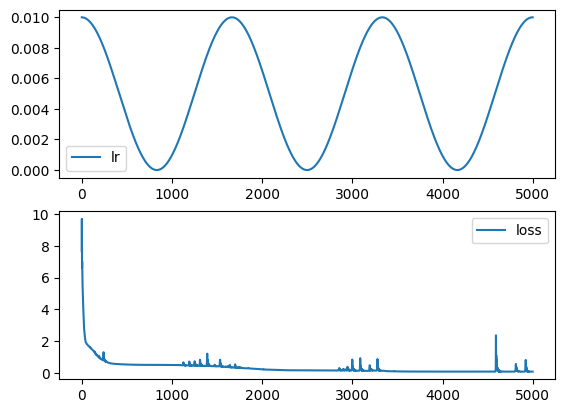

In [ ]:
lr = 0.01
num_epochs = 5000
T_scheduler = num_epochs // 6
coeff_phys1 = 1.0
coeff_phys2 = 1.0
device = "cpu"
loss_fun = torch.nn.MSELoss()

(f, _, d2f_dx2), params = get_model_and_derivatives(device=device)
optim = torch.optim.Adam(params, lr= lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)

lrs = []
losses_mse = []
losses_phys = []
losses = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

# dummy data in [-10, 10] interval
X_dummy = torch.arange(-10, 10, 0.01).to(device).reshape(-1,1)

start_time = time.time()
for epoch in range(num_epochs):
  optim.zero_grad()
  Y_pred = f(X_train)
  d2Y_dX2_pred = d2f_dx2(X_train).reshape(-1,1)
  loss_mse = loss_fun(Y_train, Y_pred)
  loss_phys1 = loss_fun(d2Y_dX2_pred, -Y_pred)

  # physics loss using dummy data (no Y available)
  Y_pred_dummy = f(X_dummy)
  d2Y_dX2_pred_dummy = d2f_dx2(X_dummy).reshape(-1,1)
  loss_phys2 = loss_fun(d2Y_dX2_pred_dummy, -Y_pred_dummy)

  loss = loss_mse + coeff_phys1 * loss_phys1 + coeff_phys2 * loss_phys2

  loss.backward(retain_graph= True)
  optim.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
  losses_mse.append(loss_mse.item())
  losses_phys.append(loss_phys.item())
  losses.append(loss.item())
  if (epoch + 1)%100 == 0:
    print(f"t: {time.time() - start_time:.2f}, Epoch: {epoch+1}: MSE: {loss_mse.item():.4f}, Phys1: {loss_phys1.item():.4f},Phys2: {loss_phys2.item():.4f},  LR: {scheduler.get_last_lr()[0]:.6f}")

plt.subplot(2, 1, 1)
plt.plot(lrs, label= 'lr')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()


MSE: 0.06191888824105263


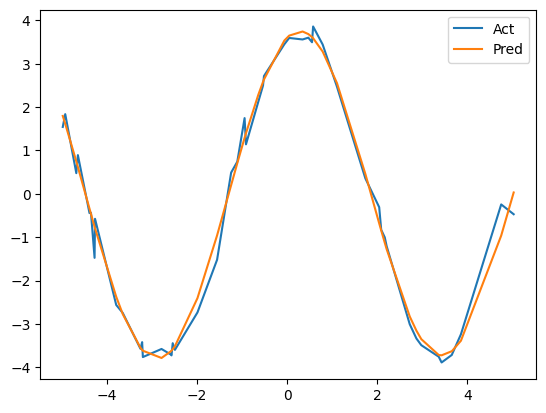

In [ ]:
test_model(f, X_train, Y_train)

MSE: 0.017685534432530403


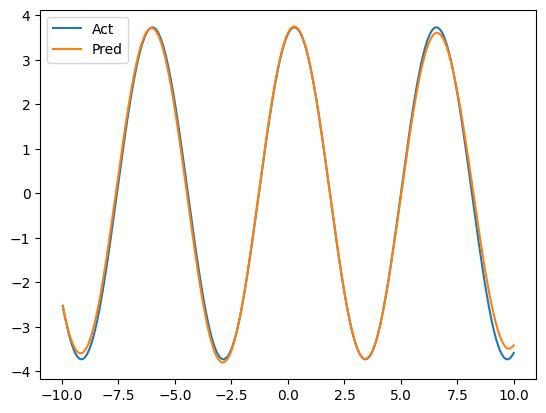

In [ ]:
test_model(f, X_test, Y_test)

We can see that even with only 50 noisy data points on [-5, 5] range, we are able to predict well outisde that range.

## HW 1:
Suggest other constraint that can be done using dummy data, something related to the periodic nature maybe?. Implement your suggestion and produce graphs. Comment on them


## ODE discovery
Find $y(x)$ that satisfies $\mathcal{N}[y,x; \omega] = \frac{d^2 y}{d x^2} + \omega ^2 y = 0$, $\omega$ is unknown

### Prepare Data

As before, but with different frequency $\omega = 1.5$ is unknown to the model, it should be learnt

In [ ]:
# Generation of synthetic dataset
def generate_data(interval = (-torch.pi, torch.pi), num_samples= 1000, A = 1.0, phi = 0.0, omega= 1.5):
  X = (interval[1]-interval[0]) * torch.rand((num_samples, 1), requires_grad= True) + interval[0]

  f = lambda x : A*torch.cos(omega* x + phi)
  Y = f(X)
  print(f"Generated dataset with {num_samples} samples, x in interval [{X.min().item():.2f}, {X.max().item():.2f}], y(x) = {A:.2f} cos({omega:.2f} x {phi:+.2f})")

  # check if the differential equation N[y,x] = 0 holds

  ## compute first derivative (jacobian)
  df_dx = vmap(jacrev(f))
  dY_dX = df_dx(X).reshape(Y.shape)

  ## compute second derivative (hessian)
  d2f_dx2 = vmap(hessian(f))
  d2Y_dX2 = d2f_dx2(X).reshape(Y.shape)

  ## compute N[y,x]
  N = d2Y_dX2 + omega * omega * Y
  if torch.allclose(torch.mean(torch.square(N)), torch.tensor(0.)) :
    print("Differential equation holds")
  else:
    print("Something went wrong, Differential equation doesn't hold")
  return (X,Y)
def generate_train_test(interval_train, num_samples_train, interval_test, num_samples_test, omega):
  A = 3* torch.rand(()) + 1 # random number between [1, 4]
  phi = 2 * torch.pi * torch.rand(()) - torch.pi # random number between [-pi, pi]
  return generate_data(interval_train, num_samples_train, A, phi, omega), generate_data(interval_test, num_samples_test, A, phi)


# very few data points + noise
(X_train, Y_train), (X_test, Y_test) = generate_train_test([-5, 5], 50, [-10, 10], 1000, 1.5)
X_train += 0.1 * torch.randn_like(X_train)
Y_train += 0.1 * torch.randn_like(Y_train)

Generated dataset with 50 samples, x in interval [-4.72, 4.78], y(x) = 2.40 cos(1.50 x -3.04)
Differential equation holds
Generated dataset with 1000 samples, x in interval [-10.00, 10.00], y(x) = 2.40 cos(1.50 x -3.04)
Differential equation holds


### Black Box DL model

t: 0.10, Epoch 100: MSE: 0.2438, LR: 0.009649
t: 0.21, Epoch 200: MSE: 0.1095, LR: 0.008644
t: 0.31, Epoch 300: MSE: 0.0442, LR: 0.007127
t: 0.41, Epoch 400: MSE: 0.0346, LR: 0.005311
t: 0.50, Epoch 500: MSE: 0.0323, LR: 0.003451
t: 0.60, Epoch 600: MSE: 0.0316, LR: 0.001809
t: 0.70, Epoch 700: MSE: 0.0313, LR: 0.000616
t: 0.79, Epoch 800: MSE: 0.0313, LR: 0.000039
t: 0.88, Epoch 900: MSE: 0.0313, LR: 0.000159
t: 0.98, Epoch 1000: MSE: 0.0311, LR: 0.000959
t: 1.07, Epoch 1100: MSE: 0.0307, LR: 0.002328
t: 1.18, Epoch 1200: MSE: 0.0307, LR: 0.004072
t: 1.28, Epoch 1300: MSE: 0.0339, LR: 0.005947
t: 1.37, Epoch 1400: MSE: 0.0316, LR: 0.007688
t: 1.46, Epoch 1500: MSE: 0.0294, LR: 0.009052
t: 1.56, Epoch 1600: MSE: 0.0281, LR: 0.009846
t: 1.64, Epoch 1700: MSE: 0.0263, LR: 0.009959
t: 1.74, Epoch 1800: MSE: 0.0243, LR: 0.009375
t: 1.83, Epoch 1900: MSE: 0.0211, LR: 0.008176
t: 1.92, Epoch 2000: MSE: 0.0190, LR: 0.006531
t: 2.02, Epoch 2100: MSE: 0.0175, LR: 0.004670
t: 2.12, Epoch 2200: M

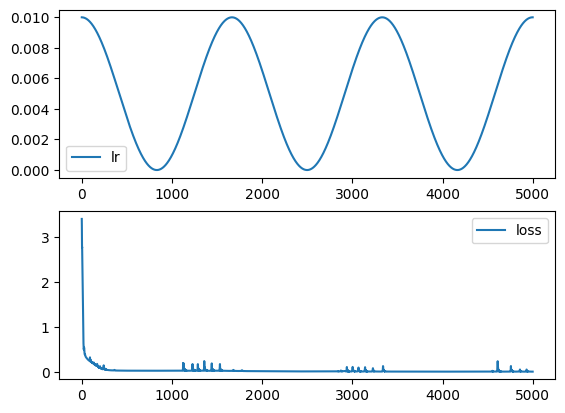

In [ ]:
lr = 0.01
num_epochs = 5000
T_scheduler = num_epochs // 6
device = "cpu"
loss_fun = torch.nn.MSELoss()

(f, _, _), params = get_model_and_derivatives(device=device)
optim = torch.optim.Adam(params, lr= lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)


lrs = []
losses = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

start_time = time.time()
for epoch in range(num_epochs):
  optim.zero_grad()
  Y_pred = f(X_train)
  loss_mse = loss_fun(Y_train, Y_pred)
  loss = loss_mse
  loss.backward(retain_graph= True)
  optim.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
  losses.append(loss.item())
  if (epoch + 1)%100 == 0:
    print(f"t: {time.time()-start_time:.2f}, Epoch {epoch+1}: MSE: {loss_mse.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

plt.subplot(2, 1, 1)
plt.plot(lrs, label= 'lr')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()


MSE: 0.010947098955512047


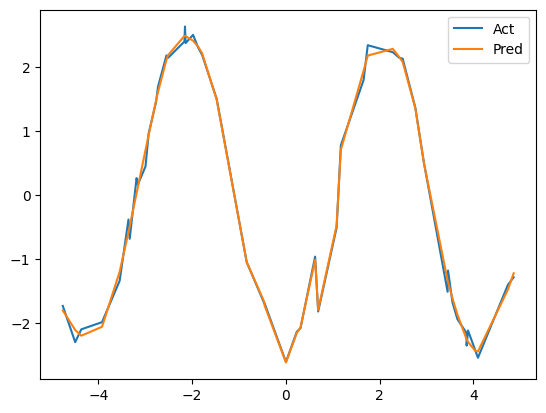

In [ ]:
test_model(f, X_train, Y_train)

MSE: 7.702691078186035


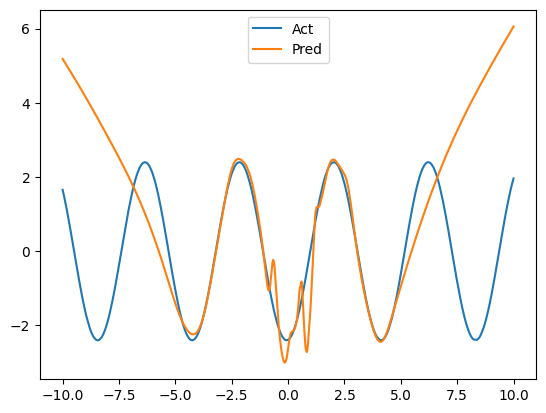

In [ ]:
test_model(f, X_test, Y_test)

We see similar behaviour as before, overfitting + poor generalization to unseen scenarios.

### PINN model: 1st try
We add a learnable parameter $\omega$.

t: 0.83, Epoch 100: MSE: 0.5279, Phys: 0.3412, LR: 0.008536, Omega: 1.09
t: 1.68, Epoch 200: MSE: 0.1324, Phys: 0.0589, LR: 0.005000, Omega: 1.23
t: 2.51, Epoch 300: MSE: 0.0611, Phys: 0.0147, LR: 0.001464, Omega: 1.35
t: 3.39, Epoch 400: MSE: 0.0580, Phys: 0.0112, LR: 0.000000, Omega: 1.36
t: 4.25, Epoch 500: MSE: 0.0552, Phys: 0.0087, LR: 0.001464, Omega: 1.37
t: 5.18, Epoch 600: MSE: 0.0551, Phys: 0.0070, LR: 0.005000, Omega: 1.39
t: 6.34, Epoch 700: MSE: 0.0551, Phys: 0.0137, LR: 0.008536, Omega: 1.38
t: 7.16, Epoch 800: MSE: 0.0445, Phys: 0.0032, LR: 0.010000, Omega: 1.44
t: 7.99, Epoch 900: MSE: 0.0525, Phys: 0.0066, LR: 0.008536, Omega: 1.41
t: 8.83, Epoch 1000: MSE: 0.0438, Phys: 0.0035, LR: 0.005000, Omega: 1.44
t: 9.65, Epoch 1100: MSE: 0.0425, Phys: 0.0029, LR: 0.001464, Omega: 1.45
t: 10.48, Epoch 1200: MSE: 0.0423, Phys: 0.0028, LR: 0.000000, Omega: 1.45
t: 11.30, Epoch 1300: MSE: 0.0421, Phys: 0.0027, LR: 0.001464, Omega: 1.45
t: 12.17, Epoch 1400: MSE: 0.0412, Phys: 0.00

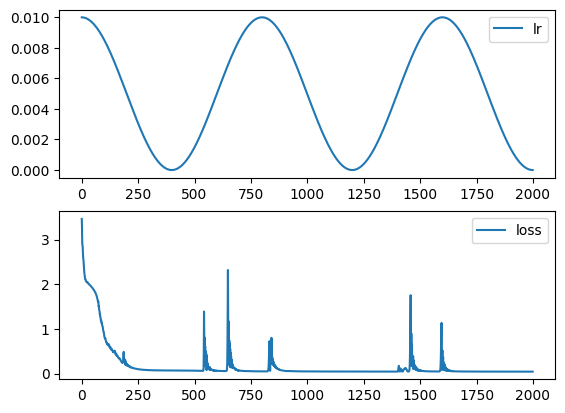

In [ ]:
# Learnable Parameter
omega_t = torch.tensor(0.01, requires_grad=True) #requires_grad is important so torch will generate gradients for this

lr = 0.01
num_epochs = 2000
T_scheduler = num_epochs // 5
coeff_phys = 1.0
device = "cpu"
loss_fun = torch.nn.MSELoss()

(f, _, d2f_dx2), params = get_model_and_derivatives(device=device)
params = [*params, omega_t] # the total set of parameters are model_parameters + omega
optim = torch.optim.Adam(params, lr= lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)

lrs = []
losses_mse = []
losses_phys = []
losses = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

start_time = time.time()
for epoch in range(num_epochs):
  optim.zero_grad()
  Y_pred = f(X_train)
  d2Y_dX2_pred = d2f_dx2(X_train).reshape(-1,1)
  loss_mse = loss_fun(Y_train, Y_pred)
  # attention to the loss formula taking into account omega
  loss_phys = loss_fun(d2Y_dX2_pred, -omega_t*omega_t*Y_pred)
  loss = loss_mse + coeff_phys * loss_phys
  loss.backward(retain_graph= True)
  optim.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
  losses_mse.append(loss_mse.item())
  losses_phys.append(loss_phys.item())
  losses.append(loss.item())
  if (epoch + 1)%100 == 0:
    print(f"t: {time.time() - start_time:.2f}, Epoch {epoch+1}: MSE: {loss_mse.item():.4f}, Phys: {loss_phys.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}, Omega: {omega_t.item():.2f}")

plt.subplot(2, 1, 1)
plt.plot(lrs, label= 'lr')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()


MSE: 0.04093340411782265


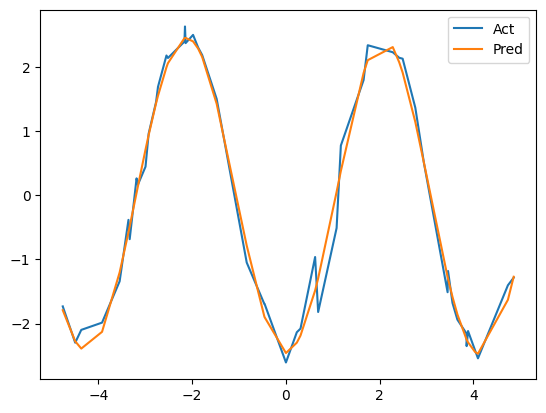

In [ ]:
test_model(f, X_train, Y_train)

MSE: 10.497589111328125


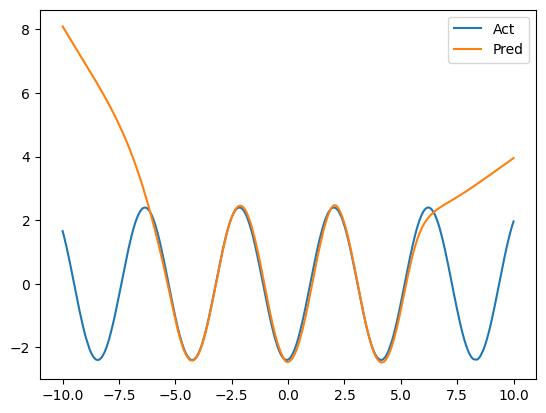

In [ ]:
test_model(f, X_test, Y_test)

## HW2:
Implement PINNs with dummy data to enhance generalization, plot graphs



## HW3:

Now we explored the case of full known DE and the case of unknown frequency. Now implement the case of unknown frequency + unknown bias, something like $y(x) = A cos(\omega x + \phi) + B$. First derive the DE operator $N$ and implement PINNs to discover and solve it.  

## HW4:
Q: Can we use ReLU activation function in the NNs of the previous tasks? why?


## HW5:
 Following the same principles use a PINNs to learn the dynamics of simplified 2D multirotor

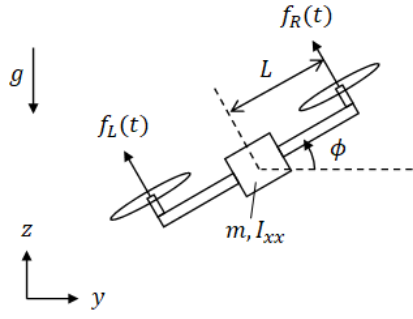

The state is $x = [y, z, \phi, v_y, v_z, \omega]$, the input is the thrust of left and right rotors $u = [f_L, f_R]$
We have the following parameters of the model (could be inaccurate)
$m = 0.35, I_{xx} = 0.005, L = 0.1, g= 9.81$

1. Derive the analytical model, define $\dot{x} = f(x, u)$

2. Create a python function to get the predicted state dynamics $\dot{x}$ based on the analytical model

In [ ]:
def f_anlyt(x, u):
  m = 0.35
  I_xx = 0.005
  L = 0.1
  g = 9.81
  #####
  # put the equations here
  # ...
  # xdot = ...
  # return xdot
  ####
  pass


In [ ]:
# Download traing and test sets
import gdown
gdown.download('https://drive.google.com/file/d/1mdCwjWupljOQH4ySLUxuTytD1Hsrzfho/view?usp=sharing', fuzzy= True)
gdown.download('https://drive.google.com/file/d/1LngllwyXvPtWD7vB-cceaFibf0UDY7N4/view?usp=sharing', fuzzy= True)

import pandas as pd

df = pd.read_csv('train.csv')

x = df[['y', 'z', 'phi', 'vy', 'vz', 'omega']].values
u = df[['ul', 'ur']].values

x_next = df[['y_next', 'z_next', 'phi_next', 'vy_next', 'vz_next', 'omega_next']].values
u_next = df[['ul_next', 'ur_next']].values

xu = np.concatenate([x, u], axis=1)
dxu = np.concatenate([x_next - x, u_next - u], axis=1)

X_train = torch.tensor(xu, dtype=torch.float32)
dX_train = torch.tensor(dxu, dtype=torch.float32)
Y_train = torch.tensor(x_next, dtype=torch.float32)

# incuce noise
X_train += 0.1 * torch.randn_like(X_train)
Y_train += 0.1 * torch.randn_like(Y_train)

# decrease number of samples
frac_samples = 10
X_train = X_train[::frac_samples]
dX_train = dX_train[::frac_samples]
Y_train = Y_train[::frac_samples]

df_test = pd.read_csv('test.csv')

x = df_test[['y', 'z', 'phi', 'vy', 'vz', 'omega']].values
u = df_test[['ul', 'ur']].values
x_next = df_test[['y_next', 'z_next', 'phi_next', 'vy_next', 'vz_next', 'omega_next']].values
xu = np.concatenate([x, u], axis=1)

X_test = torch.tensor(xu, dtype=torch.float32)
Y_test = torch.tensor(x_next, dtype=torch.float32)

X_train.shape, dX_train.shape, Y_train.shape, X_test.shape, Y_test.shape

3. Create a deep learning model that predict the next state $x_{k+1} = f_{NN}(x_k, u_k)$

In [ ]:
class Model(torch.nn.Module):
  def __init__():
    #your code here
    pass
  def forward(x, u):
    # your code here
    # x_next = ...
    return x_next

4. Create the learning pipeline with the loss:

$\mathcal{L}_{d} = \frac{1}{N-1}\sum_{k=2}^{N}{\|f_{NN}(x_{k-1},
				            u_{k-1}; \theta) - x_{k}\|^2}$

$\mathcal{L}_{ph} = \frac{1}{N-1}\sum_{k=2}^{N}{\| \frac{\partial
					            f_{NN}}{\partial x}(x_k, u_k; \theta) \Delta x_k + \frac{\partial
					            f_{NN}}{\partial u}(x_k, u_k; \theta) \Delta u_k - f_{anlt}(x_k, u_k) \Delta
				            t\|^2}$

 $\mathcal{L} = \mathcal{L}_{d} + \gamma \mathcal{L}_{ph}$

Train the model on the train dataset


5. comapre between the analytical model and the trained model on the test dataset